In [ ]:
import tensorflow as tf
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

В этот набор данных включены замеры 14 различных метеорологических показателей (таких, как температура воздуха, атмосферное давление, влажность), выполняющиеся каждые 10 минут и будут использоваться данные, охватывающие период с 2009 по 2016 год.

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 0s 0us/step


In [ ]:
df = pd.read_csv(csv_path)
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Прогнозирование одномерного временного ряда

Приведенная ниже функция возвращает вышеописанные временные интервалы для обучения модели. Аргумент history_size — это размер последнего временного интервала, target_size – аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать. Другими словами, target_size – это целевой вектор, который необходимо спрогнозировать.

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Трансформация данных из (history_size,) в (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

В обеих частях руководства первые 300 000 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации (проверки). В этом случае объём обучающих данных составляет примерно 2100 дней.


In [ ]:
TRAIN_SPLIT = 300000

Для обеспечения воспроизводимости результатов устанавливается функция seed.

In [ ]:
tf.random.set_seed(13)

Прогнозирование на основе одномерного временного ряда
В первой части обучаем модель, используя только один признак – температуру; обученная модель будет использоваться для прогнозирования будущих значений температуры.
Для начала извлечем только температуру из набора данных.

In [ ]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<Axes: xlabel='Date Time'>], dtype=object)

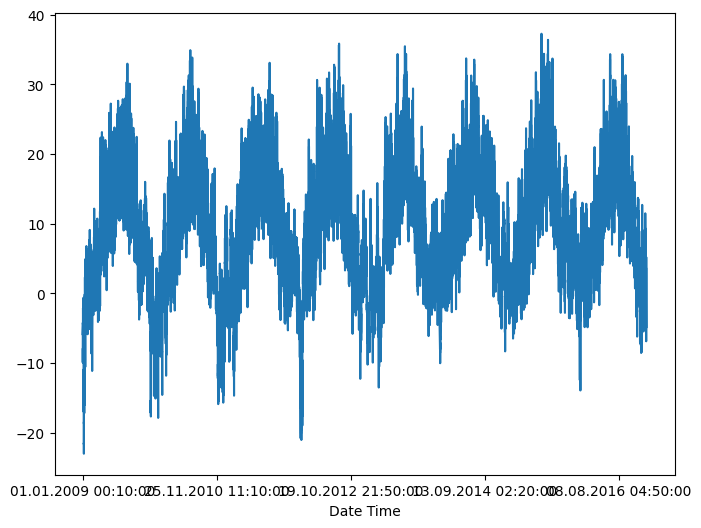

In [ ]:
uni_data.plot(subplots=True)

Выполняем стандартизацию только c использованием обучающих данных

In [ ]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

Далее подготовим данные для модели с одномерным входом. На вход в модель будут подаваться последние 20 зарегистрированных наблюдений за температурой, и модель необходимо обучить прогнозировать температуру на следующем шаге по времени.

In [ ]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)
print ('История температур')
print (x_train_uni[0])
print ('\n Предсказанная температура')
print (y_train_uni[0])

История температур
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Предсказанная температура
-2.1041848598100876


Теперь, когда данные соответствующим образом подготовлены, рассмотрим конкретный пример. Передаваемая в ИНС информация выделена синим цветом, красным крестиком обозначено будущее значение, которое ИНС должна спрогнозировать.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

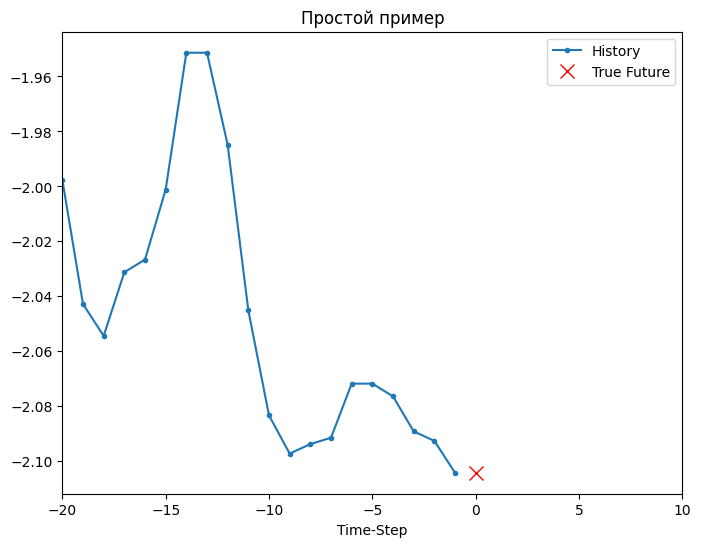

In [ ]:
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Простой пример')

Прежде чем приступить к обучению модели, установим простое базовое решение (baseline). Оно заключается в следующем: для заданного входного вектора метод базового решения «просматривает» всю историю и прогнозирует следующее значение как среднее из последних 20 наблюдений.
Делаем для того, чтобы сравнить наш прогнос со средним и узнать насколько он лучше.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

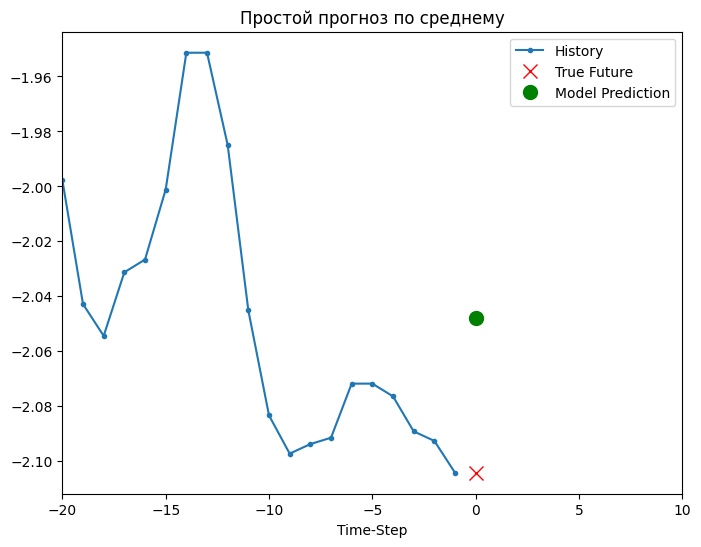

In [ ]:
def baseline(history):
  return np.mean(history)
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Простой прогноз по среднему')

Далее с помощью tf.data выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных.

In [ ]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Рекуррентная нейронная сеть (РНС) — это тип, который хорошо подходит для решения задач, связанных с временными рядами. РНС шаг за шагом обрабатывает временную последовательность данных, перебирая её элементы и сохраняя внутреннее состояние, полученное при обработке предыдущих элементов. Будет использоваться специализированный слой, который называется «Долгая краткосрочная память» (англ. Long Short-Term Memory, LSTM).
LSTM требует определённой формы ввода данных, которые ему предоставляются.

In [ ]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

8/8 [==============================] - 2s 7ms/step
(256, 1)


Далее обучение модели

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 11s 34ms/step - loss: 0.3397 - val_loss: 0.0641
Epoch 2/10
200/200 [==============================] - 5s 26ms/step - loss: 0.0835 - val_loss: 0.0337
Epoch 3/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0461 - val_loss: 0.0267
Epoch 4/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0412 - val_loss: 0.0234
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0283 - val_loss: 0.0219
Epoch 6/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0299 - val_loss: 0.0207
Epoch 7/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0268 - val_loss: 0.0197
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0257 - val_loss: 0.0194
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0246 - val_loss: 0.0178
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0225 - val_l

8/8 [==============================] - 0s 4ms/step


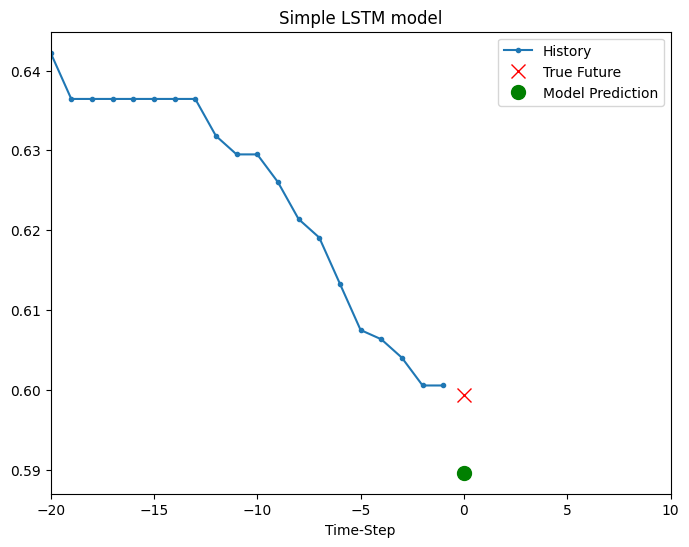

8/8 [==============================] - 0s 5ms/step


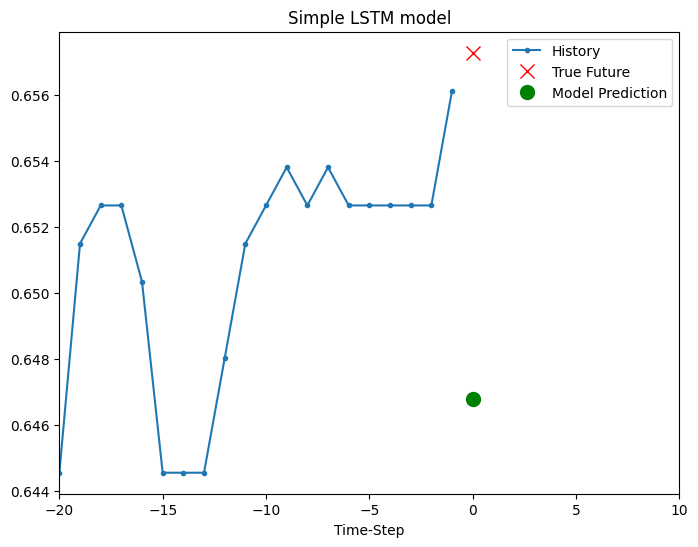

8/8 [==============================] - 0s 4ms/step


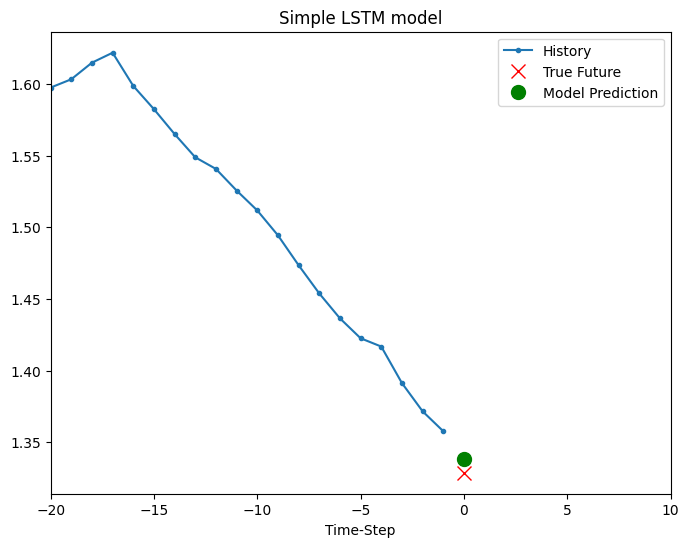

In [ ]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

## Многомерный временной ряд
- Тут мы берем парметры: температура воздуха, атмосферное давление и плотность воздуха.

In [ ]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)'] # Выбираем параметры давление, температура и влажность
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

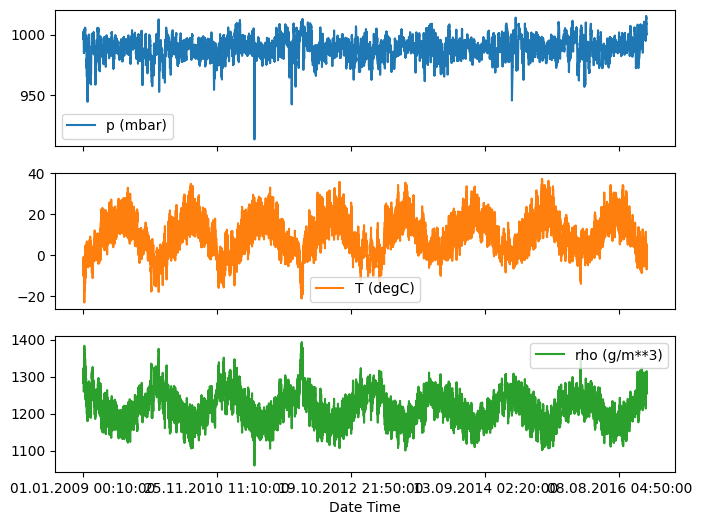

In [ ]:
features.plot(subplots=True) # Графики параметров

Выполнение стандартизации набора данных с вычислением среднего значения и стандартного отклонения обучающих данных.

In [ ]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

В данном случае модель обучается прогнозированию одного значения в будущем на основе некой имеющейся истории.
Приведенная ниже функция выполняет ту же задачу организации временных интервалов лишь с тем отличием, что здесь она отбирает последние наблюдения на основе заданного размера шага.

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

ИНС оперирует данными за последние пять (5) дней, то есть 720 наблюдениями (6х24х5). Допустим, что отбор данных проводится не каждые 10 минут, а каждый час: в течение 60 минут резкие изменения не ожидаются. Следовательно, историю последних пяти дней составляют 120 наблюдений (720/6). Для модели, выполняющей точечное прогнозирование, целью является значение температуры через 12 часов в будущем.

In [ ]:
past_history = 720
future_target = 72
STEP = 6
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

- В этом случае на основе некой имеющейся истории модель обучается прогнозированию интервала будущих значений. Таким образом, в отличие модели, прогнозирующей только на одно значение в будущее, данная модель прогнозирует последовательность значений в будущем.
- Допустим, как и в случае с моделью, выполняющей точечное прогнозирование, для модели, выполняющей интервальное прогнозирование, обучающими данными являются почасовые замеры последних пяти дней (720/6). Однако в данном случае модель необходимо обучить прогнозировать температуру на следующие 12 часов. Поскольку наблюдения регистрируются каждые 10 минут, выход (output) модели должен состоять из 72 прогнозов. Для выполнения этой задачи необходимо подготовить набор данных заново, но с другим целевым интервалом.

In [ ]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Подготовим визуализацию.

In [ ]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

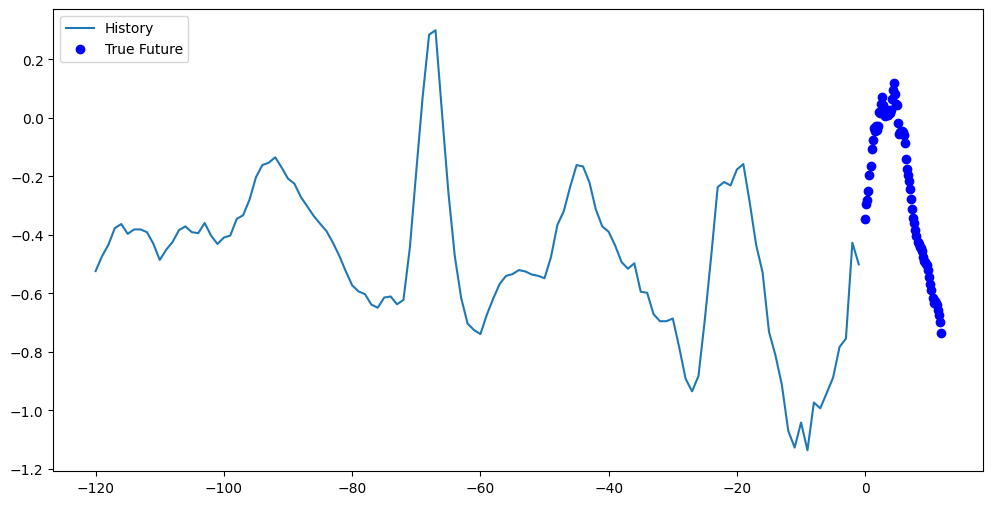

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Так как эта задача немного сложнее, чем предыдущая, то модель будет состоять из двух слоёв LSTM. Наконец, поскольку выполняется 72 прогноза, выход слой насчитывает 72 нейрона.

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

8/8 [==============================] - 1s 23ms/step
(256, 72)


In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 47s 215ms/step - loss: 0.5337 - val_loss: 0.2921
Epoch 2/10
200/200 [==============================] - 44s 221ms/step - loss: 0.3387 - val_loss: 0.2803
Epoch 3/10
200/200 [==============================] - 44s 218ms/step - loss: 0.3048 - val_loss: 0.2409
Epoch 4/10
200/200 [==============================] - 43s 214ms/step - loss: 0.2448 - val_loss: 0.2162
Epoch 5/10
200/200 [==============================] - 43s 213ms/step - loss: 0.2019 - val_loss: 0.2156
Epoch 6/10
200/200 [==============================] - 44s 219ms/step - loss: 0.2117 - val_loss: 0.2057
Epoch 7/10
200/200 [==============================] - 42s 210ms/step - loss: 0.2031 - val_loss: 0.2175
Epoch 8/10
200/200 [==============================] - 42s 208ms/step - loss: 0.1995 - val_loss: 0.1958
Epoch 9/10
200/200 [==============================] - 42s 208ms/step - loss: 0.2019 - val_loss: 0.1923
Epoch 10/10
200/200 [==============================] - 42s 210ms/step - l

Выполнение интервального прогноза

8/8 [==============================] - 0s 52ms/step


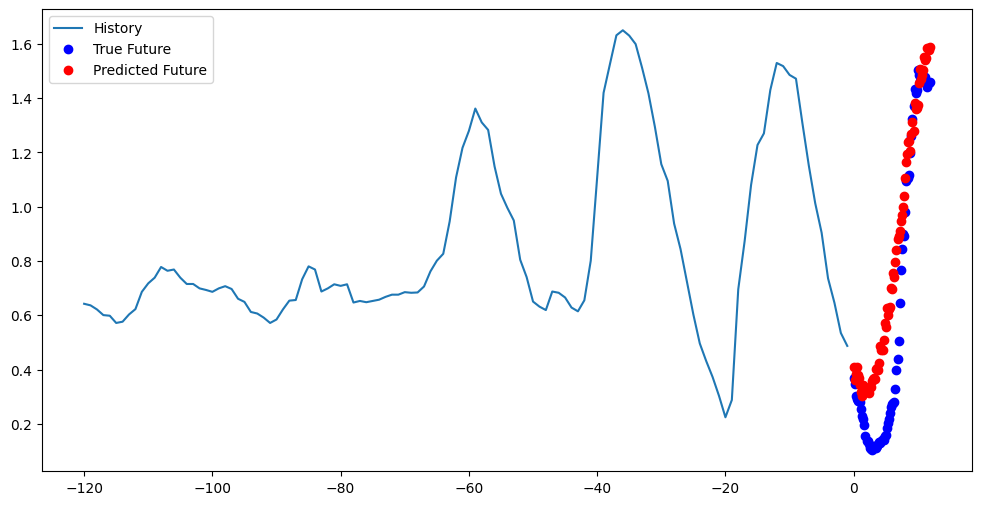

8/8 [==============================] - 1s 73ms/step


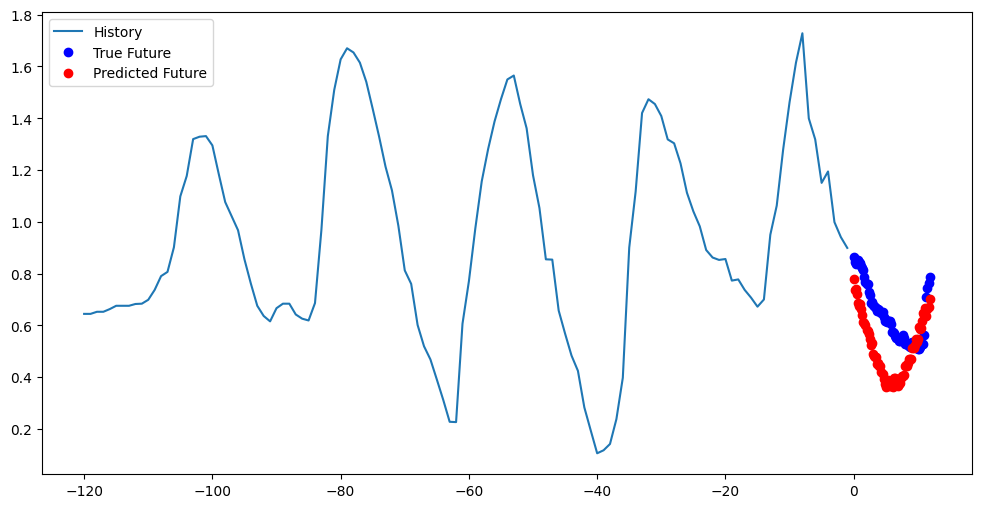

8/8 [==============================] - 1s 68ms/step


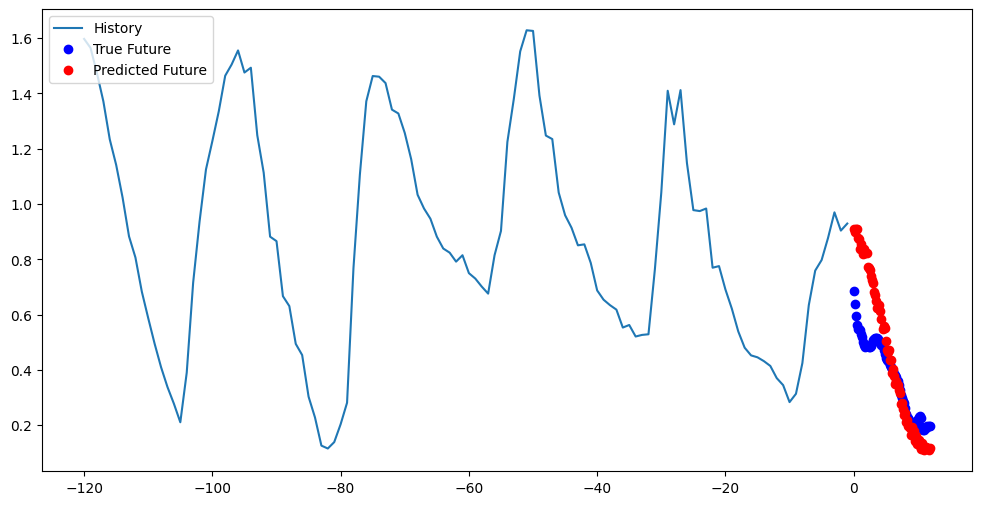

In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])